In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read data
df_density = pd.read_excel('../../density.xlsx')
df_data = pd.read_csv('../data/coople_data.csv')
df_lat = pd.read_csv('../../post-codes.csv')

In [78]:
df_urban = df_data.merge(df_density, on = 'Post Code',how = 'left')
df_urban.set_index('Rank', inplace=True)

In [79]:
df_urban = df_urban.drop(['City_y'],axis=1)
df_urban = df_urban.rename(columns={'City_x': 'City'})
df_urban = df_urban.dropna(subset = ['Density'])
df_urban_lat = df_urban.merge(df_lat.drop_duplicates(['Post Code']), on = 'Post Code',how = 'left')
df_urban.head()

,Unnamed: 0,Job role,Experience Level,Experience detail,Job description,Industry,City,Post Code,Pay total,Pay per hour,Start date,Shift,Region,Population,Area,Density
Rank,,,,,,,,,,,,,,,,
1,0,Service Gastronomie,Ungelernt mit >20 Monaten Erfahrung,Personen ohne eidgenössisches Fähigkeitszeugni...,Travail usuel de chef de rang:\n- Mise en plac...,Gastronomie / Hotel,Neuchâtel,2000,227.25,30.30,22 Aug 2023,1,Canton of Neuchâtel,32376.0,31.600,1024.556962
2,1,Logistiker/in,Ungelernt,Personen mit Bereitschaft zu körperlicher Arbe...,Funktionsumschreibung\n* Der/Die Rangierdienst...,Promotion / Event,Spreitenbach,8957,34444.75,29.00,22 Aug 2023,132,Aargau,11587.0,8.600,1347.325581
3,2,Verkaufsmitarbeiter/in / Detailhandel,Ungelernt,Verkaufsmitarbeiter/in mit Freude am Verkauf u...,Aufgaben:\n- Auffülltätigkeiten (Non Food Bere...,Detailhandel / Logistik,Rüschlikon,8803,16605.00,27.00,23 Aug 2023,82,Canton of Zürich,6769.0,4.632,1461.355786
5,4,Logistiker/in,Ungelernt mit >20 Monaten Erfahrung,Der Nachweis über >20 Monate Praxiserfahrung i...,!Die Einsatzzeiten im sind fiktiv!Den genauen ...,Promotion / Event,Willisau,6130,6048.00,27.00,23 Aug 2023,28,Canton of Lucerne,6931.0,33.400,207.514970
6,5,Handwerk & Auf-/Abbau,Ungelernt,Personen mit Bereitschaft zu körperlicher Arbe...,Anlagenbetreuer Tiefkühl\n\n \n\nAufgaben\n\n-...,Promotion / Event,Schafisheim,5503,42327.25,25.46,23 Aug 2023,190,Aargau,2848.0,6.300,452.063492


In [80]:
density = df_urban['Density']
print(min(density),np.mean(density),max(density))

7.8827361563517915 2944.5535389740053 16202.3988005997


In [81]:
df_urban['Urban'] = df_urban['Density'] > 400

In [82]:
urban_total = df_urban['Urban'].sum()/df_urban['Urban'].count()
urban_total

0.8675388389206868

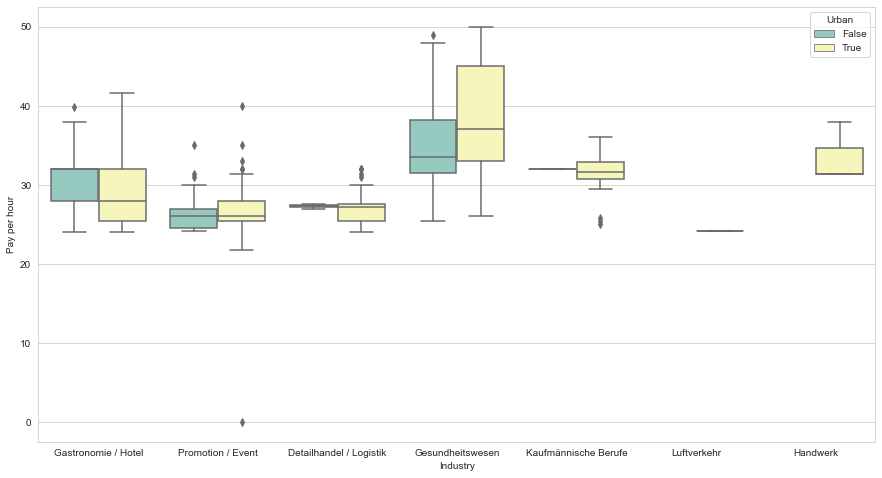

In [83]:
import seaborn as sns
sns.set_style("whitegrid")
plt.figure(figsize=(15,8))
ax = sns.boxplot(x="Industry", y="Pay per hour", hue="Urban",              
data=df_urban, palette="Set3")

In [84]:
# Urban data group by post code
df_count = df_urban.groupby(['Post Code']).size().reset_index(name = 'Counts')
df_count

,Post Code,Counts
0,1003,3
1,1006,11
2,1010,1
3,1022,1
4,1024,3
...,...,...
316,9515,2
317,9542,1
318,9555,2
319,9565,2


In [87]:
# Merge grouped aby data with density.csv
df = df_count.merge(df_density,on = 'Post Code',how = 'left')
df['gig_per'] = 100*df['Counts']/df['Population']
# Define urban column
df['urban'] = 'unknown'
df.loc[df['Density']<400, 'urban'] = 'rural'
df.loc[(df['Density']>=400) & (df['Density']<1500), 'urban'] = 'urban'
df.loc[df['Density']>1500, 'urban'] = 'urban center'
df.head()

,Post Code,Counts,City,Region,Population,Area,Density,gig_per,urban
0,1003,3,Lausanne,Vaud,7617.0,0.820,9289.024390,0.039386,urban center
1,1006,11,Lausanne,Vaud,11538.0,1.553,7429.491307,0.095337,urban center
2,1010,1,Lausanne,Vaud,14897.0,2.856,5216.036415,0.006713,urban center
3,1022,1,NaN,Vaud,6734.0,1.662,4051.744886,0.014850,urban center
4,1024,3,Chavannes-près-Renens,Vaud,8810.0,4.829,1824.394285,0.034052,urban center


In [86]:
# Count job number of urban center, urban and rural 
urban_count = df.groupby('urban')['urban'].count()
urban_count

urban
rural            79
urban           131
urban center    116
Name: urban, dtype: int64

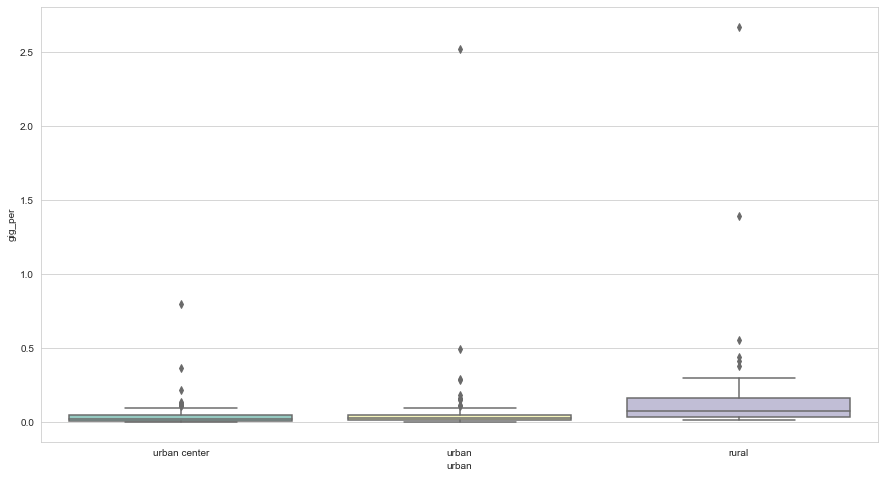

In [89]:
import seaborn as sns
sns.set_style("whitegrid")
plt.figure(figsize=(15,8))
ax = sns.boxplot(x="urban", y="gig_per",               
data=df, palette="Set3")

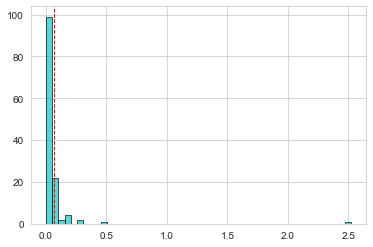

In [99]:
urban = df[df["urban"]=='urban']['gig_per']
urban_center = df[df["urban"]=='urban center']['gig_per']
rural = df[df["urban"]=='rural']['gig_per']
plt.hist(urban, color = 'c', edgecolor='black',alpha=0.65,bins = 50)
plt.axvline(urban.mean(), color='r', linestyle='dashed', linewidth=1)

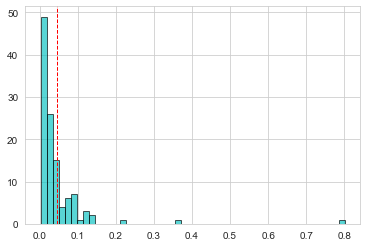

In [100]:
plt.hist(urban_center, color = 'c', edgecolor='black',alpha=0.65,bins = 50)
plt.axvline(urban_center.mean(), color='r', linestyle='dashed', linewidth=1)

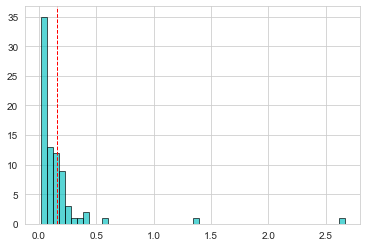

In [101]:
plt.hist(rural, color = 'c', edgecolor='black',alpha=0.65,bins = 50)
plt.axvline(rural.mean(), color='r', linestyle='dashed', linewidth=1)

In [30]:
df_urban.to_csv('../data/urban_data.csv')
df_urban_lat.to_csv('../data/urban_data_lat.csv')
df.to_csv('../data/urban_group.csv')